In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore")

In [2]:
simulation_data_pd = pd.read_csv("/root/research/Deep-Learning-Research/sermantic-spectral-entropy/notebook/generated_data_all_llm.csv", index_col= 0,)

In [4]:
def text_to_number_phi(t: str, if_none :int = 0) -> int:
    assert(if_none in [0, 1])
    if type(t) == type(" "):
        t = t.upper().replace(" ","")
        if t == "TRUE":
            return 1
        elif t == "FALSE":
            return 0
        else:
            return if_none
    if type(t) == type(True):
        return bool_to_number(t)

def bool_to_number(t: bool) -> int:
    if t:
        return 1
    else:
        return 0 

In [5]:
from collections.abc import Callable
def build_matrix(data: pd.DataFrame, transform_to_number: Callable, result_column_name: str):
    N = np.max(data[["index_1","index_2"]])+1
    M = np.zeros((N,N))
    outcome = []
    for i, j, k in zip(data["index_1"], data["index_2"], data[result_column_name]):
        value = transform_to_number(k)
        M[i][j] = value
        outcome.append(value)

    data["outcome"] = outcome
    M = M + M.T
    p = np.mean(data["outcome"][data["label_1"] == data["label_2"]])
    q = np.mean(data["outcome"][data["label_1"] != data["label_2"]])
    return M, p ,q 

In [16]:
def find_entropy(M,K):
    spec = SpectralClustering(n_clusters=K, affinity= "precomputed", assign_labels='kmeans',random_state = 1234)
    return compute_entropy(spec.fit_predict(M))

def compute_entropy(data):
    _, count = np.unique(data, return_counts= True )          
    entropy_value = entropy(count/np.sum(count))
    return entropy_value


def general_compute(simulation_data_pd, identification = "phi", transform_to_number = text_to_number_phi):
    entropy_computed = []
    abs_diff         = []
    p_value   = []
    q_value   = []
    for i in range(simulation_data_pd.shape[0]):
        row = simulation_data_pd.iloc[i]
        data = pd.read_csv(simulation_data_pd["phi_identified_file_name"].iloc[i],index_col=0)
        K = len(row['ratio'].split("_"))
        M, p, q = build_matrix(data,  transform_to_number, identification+"_identification")
        p_value.append(p)
        q_value.append(q)
        E = find_entropy(M,K)
        entropy_computed.append(E)
        truth = row['empirical_entropy'] 
        abs_diff.append(np.abs(E-truth))
    simulation_data_pd[identification + "_entropy_computed"] = entropy_computed
    simulation_data_pd[identification + "_abs_diff"] = abs_diff
    simulation_data_pd[identification + "_prop_diff"] = abs_diff/truth
    simulation_data_pd[identification + "_p_value"] = p_value
    simulation_data_pd[identification + "_q_value"] = q_value
    return simulation_data_pd

In [17]:
import warnings
warnings.filterwarnings("ignore")
output_phi       = general_compute(simulation_data_pd)
output_gpt       = general_compute(simulation_data_pd, "gpt")
output_Ministral = general_compute(output_gpt, "Ministral")
output_Llama     = general_compute(output_Ministral, "Llama")
output_Cohere    = general_compute(output_Llama, "Cohere")
output_A21       = general_compute(output_Cohere, "A21")
output_phi       = general_compute(output_A21, "phi")

In [18]:
output_phi 

,Unnamed: 0.1,Unnamed: 0,seed,data_size,ratio,empirical_entropy,file_name,phi_identified_file_name,phi_time,A21_time,...,Cohere_entropy_computed,Cohere_abs_diff,Cohere_prop_diff,Cohere_p_value,Cohere_q_value,A21_entropy_computed,A21_abs_diff,A21_prop_diff,A21_p_value,A21_q_value
0,0,0,10,30,0.5_0.5,0.684232,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,89.957649,105.954038,...,0.684232,0.000000e+00,0.000000e+00,0.490654,0.000000,0.684232,0.000000e+00,0.000000e+00,0.943925,0.000000
1,1,1,10,30,0.2_0.3_0.5,1.052139,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,90.260053,104.736676,...,1.052139,2.220446e-16,2.089367e-16,0.662162,0.059233,1.052139,2.220446e-16,2.089367e-16,0.993243,0.344948
2,2,2,10,30,0.3_0.3_0.4,1.095273,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,89.668723,104.828308,...,1.027517,6.775636e-02,6.375653e-02,0.529412,0.010033,1.095273,0.000000e+00,0.000000e+00,0.904412,0.006689
3,3,3,10,50,0.5_0.5,0.685930,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,250.624048,294.688496,...,0.685930,0.000000e+00,0.000000e+00,0.484401,0.000000,0.685930,0.000000e+00,0.000000e+00,0.929392,0.000000
4,4,4,10,50,0.2_0.3_0.5,1.061135,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,252.327968,296.761199,...,1.061135,0.000000e+00,0.000000e+00,0.481043,0.024907,1.061135,0.000000e+00,0.000000e+00,0.874408,0.032379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,85,19,50,0.2_0.3_0.5,0.987145,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,251.217243,300.035771,...,0.987145,0.000000e+00,0.000000e+00,0.576446,0.006748,0.987145,0.000000e+00,0.000000e+00,0.985537,0.029690
86,86,86,19,50,0.3_0.3_0.4,1.063873,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,252.846397,297.309468,...,1.063873,0.000000e+00,0.000000e+00,0.547393,0.018680,1.063873,0.000000e+00,0.000000e+00,0.983412,0.169365
87,87,87,19,70,0.5_0.5,0.689469,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,498.195830,590.638722,...,0.689469,0.000000e+00,0.000000e+00,0.729775,0.000000,0.689469,0.000000e+00,0.000000e+00,0.984153,0.000000
88,88,88,19,70,0.2_0.3_0.5,1.046033,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,497.230290,590.630816,...,1.046033,2.220446e-16,2.089367e-16,0.632606,0.013601,1.046033,2.220446e-16,2.089367e-16,0.967853,0.059585


In [19]:
general_output = output_phi[['data_size', 'ratio','phi_time', 'A21_time','Cohere_time', 'Ministral_time', 'Llama_time','gpt_entropy_computed', 'gpt_abs_diff',\
        'gpt_prop_diff', 'gpt_p_value', 'gpt_q_value','Ministral_entropy_computed', 'Ministral_abs_diff',\
        'Ministral_prop_diff', 'Ministral_p_value', 'Ministral_q_value','Llama_entropy_computed', 'Llama_abs_diff', 'Llama_prop_diff',\
        'Llama_p_value', 'Llama_q_value', 'Cohere_entropy_computed','Cohere_abs_diff', 'Cohere_prop_diff', 'Cohere_p_value',\
        'Cohere_q_value', 'A21_entropy_computed', 'A21_abs_diff','A21_prop_diff', 'A21_p_value', 'A21_q_value', 'phi_entropy_computed',\
            'phi_abs_diff', 'phi_prop_diff', 'phi_p_value', 'phi_q_value']].groupby(["ratio","data_size"]).agg("mean").T

In [20]:
print(general_output.loc[['gpt_abs_diff','Ministral_abs_diff', 'Llama_abs_diff','Cohere_abs_diff','A21_abs_diff','phi_abs_diff']].to_latex( formatters={"name": str.upper},float_format="{:.2f}".format,))

\begin{tabular}{lrrrrrrrrr}
\toprule
ratio & \multicolumn{3}{r}{0.2_0.3_0.5} & \multicolumn{3}{r}{0.3_0.3_0.4} & \multicolumn{3}{r}{0.5_0.5} \\
data_size & 30 & 50 & 70 & 30 & 50 & 70 & 30 & 50 & 70 \\
\midrule
gpt_abs_diff & 0.06 & 0.02 & 0.00 & 0.01 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Ministral_abs_diff & 0.21 & 0.27 & 0.13 & 0.25 & 0.23 & 0.21 & 0.14 & 0.22 & 0.21 \\
Llama_abs_diff & 0.33 & 0.39 & 0.54 & 0.38 & 0.47 & 0.48 & 0.28 & 0.27 & 0.25 \\
Cohere_abs_diff & 0.04 & 0.02 & 0.06 & 0.02 & 0.03 & 0.00 & 0.00 & 0.00 & 0.00 \\
A21_abs_diff & 0.05 & 0.00 & 0.00 & 0.00 & 0.01 & 0.00 & 0.00 & 0.00 & 0.00 \\
phi_abs_diff & 0.05 & 0.03 & 0.03 & 0.02 & 0.06 & 0.00 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



In [21]:
import matplotlib.pyplot as plt

In [22]:
A21_data = output_phi[[ 'A21_p_value', 'A21_q_value', 'A21_abs_diff','data_size']].rename(columns={'A21_p_value':'p', 'A21_q_value':'q',  'A21_abs_diff': 'diff'})
A21_data["type"] = "A21"
phi_data = output_phi[[ 'phi_p_value', 'phi_q_value', 'phi_abs_diff','data_size']].rename(columns={'phi_p_value':'p', 'phi_q_value':'q',  'phi_abs_diff': 'diff'})
phi_data["type"] = "Phi"
gpt_data = output_phi[[ 'gpt_p_value', 'gpt_q_value', 'gpt_abs_diff','data_size']].rename(columns={'gpt_p_value':'p', 'gpt_q_value':'q',  'gpt_abs_diff': 'diff'})
Cohere_data = output_phi[[ 'Cohere_p_value', 'Cohere_q_value', 'Cohere_abs_diff','data_size']].rename(columns={'Cohere_p_value':'p', 'Cohere_q_value':'q',  'Cohere_abs_diff': 'diff'})
Llama_data = output_phi[[ 'Llama_p_value', 'Llama_q_value', 'Llama_abs_diff','data_size']].rename(columns={'Llama_p_value':'p', 'Llama_q_value':'q',  'Llama_abs_diff': 'diff'})
Ministral_data = output_phi[[ 'Ministral_p_value', 'Ministral_q_value', 'Ministral_abs_diff','data_size']].rename(columns={'Ministral_p_value':'p', 'Ministral_q_value':'q',  'Ministral_abs_diff': 'diff'})


In [24]:
data_list = []
for i in ["A21", 'phi', 'gpt', 'Cohere', "Llama", "Ministral"]:
    data = output_phi[[i+'_p_value', i+'_q_value', i+'_abs_diff', i+'_entropy_computed',i + '_time', 'data_size', 'ratio','empirical_entropy'  ]].rename(columns={i+'_p_value': 'p', i+'_q_value': 'q', i+'_abs_diff':'diff', i+'_entropy_computed': 'entropy_computed',i + '_time':'time'})
    data['e'] = i.upper()
    data['cluster_size'] = data['ratio'].apply(lambda x: len(x.split('_')))
    data['lambda'] = (data['p']- data['q'])
    data_list.append(data)

In [25]:
full_data = pd.concat(data_list)

In [26]:
print(full_data[['lambda','p','q','e']].groupby(['e']).agg('mean').to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrr}
\toprule
 & lambda & p & q \\
e &  &  &  \\
\midrule
A21 & 0.81 & 0.96 & 0.15 \\
COHERE & 0.55 & 0.61 & 0.05 \\
GPT & 0.80 & 0.87 & 0.07 \\
LLAMA & 0.17 & 0.17 & 0.00 \\
MINISTRAL & 0.22 & 0.99 & 0.77 \\
PHI & 0.67 & 0.67 & 0.01 \\
\bottomrule
\end{tabular}



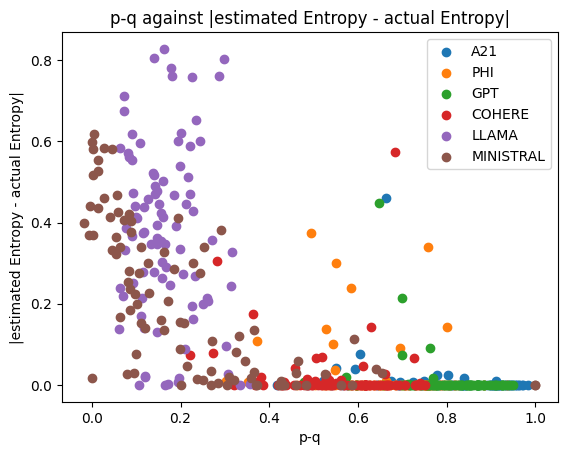

In [27]:
colormap = ["A21", 'phi', 'gpt', 'Cohere', "Llama", "Ministral"]
for i in data_list:
    plt.scatter(i["lambda"], i['diff'], label = i['e'].iloc[1])
plt.legend(loc= 'upper right')
plt.title("p-q against |estimated Entropy - actual Entropy|")
plt.xlabel("p-q")
plt.ylabel("|estimated Entropy - actual Entropy|")
plt.savefig('/root/research/Deep-Learning-Research/Notebook/LambdaExp1.pdf')